In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
import os
# os.environ['AUTOGRAPH_VERBOSITY'] = '1'

## TensorFlowのメカニズム

#### 1.TensorFlowの主な特徴
#### 2.TensorFlowの計算グラフ
#### 3.TensorFlowのVariableオブジェクト
#### 4.自動微分とGradientTapeによる勾配の計算
#### 5.Keras APIを使って一般的なアーキテクチャの実装を単純化する
#### 6.TensorFlow Estimator

In [2]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()

tf.print(init(shape=(3,)))# GlorotNormalクラスのオブジェクトとしてinitという演算子を作成

[-0.722795904 1.01456821 0.251808226]


In [3]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.28982234 -0.782292783 -0.0453658961]
 [0.960991383 -0.120003454 0.708528221]]


In [4]:
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)
                
m = MyModule()
print('All module variables: ', [v.shape for v in m.variables])
print('Trainable variable:   ', [v.shape for v in
                                 m.trainable_variables])

All module variables:  [TensorShape([2, 3]), TensorShape([1, 2])]
Trainable variable:    [TensorShape([2, 3])]


In [5]:
tf.random.set_seed(1)
w = tf.Variable(tf.random.uniform((3, 3)))

@tf.autograph.experimental.do_not_convert
def compute_z(x):    
    return tf.matmul(w, x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)
tf.print(compute_z(x))

[[3.8610158]
 [2.94593048]
 [3.82629013]]


### 14.4 自動微分とGradientTapeによる勾配の計算

##### 勾配を知る -> モデルの診断
##### 入れ子の関数の勾配を計算するための連鎖律の実装
##### １つの勾配計算のリソースしか保持しない（複数の勾配を計算したい場合は、引数を指定）

In [2]:
w = tf.Variable(1.0)  # モデルパラメータ w と ｂ を変数として定義
b = tf.Variable(0.5)
print(w.trainable, b.trainable)  # 訓練可能な変数であることを確認

x = tf.convert_to_tensor([1.4, 3])
y = tf.convert_to_tensor([2.1, 5])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)  # wx + b
    loss = tf.reduce_sum(tf.square(y - z))  # 損失項 (二乗誤差)

dloss_dw = tape.gradient(loss, w)  # d Loss/dw

tf.print('dL/dw : ', dloss_dw)

True True
dL/dw :  -9.55999947


In [ ]:
w

In [3]:
tf.add(tf.multiply(w, x), b)  # z = wx + b

<tf.Tensor: id=53, shape=(2,), dtype=float32, numpy=array([1.9, 3.5], dtype=float32)>

In [4]:
tf.reduce_sum(tf.square(y-z))  # loss

<tf.Tensor: id=57, shape=(), dtype=float32, numpy=2.29>

In [5]:
# verifying the computed gradient

tf.print(2*x * ((w*x + b) - y))

[-0.559999764 -9]


##### 訓練可能ではない変数について勾配を計算する

In [6]:
with tf.GradientTape() as tape:
    tape.watch(x)  # x:Tensorオブジェクト
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dx = tape.gradient(loss, x)

tf.print('dL/dx:', dloss_dx)


dL/dx: [-0.399999857 -3]


In [7]:
dloss_db = tape.gradient(loss, b)

RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.

In [8]:
0.2*x

<tf.Tensor: id=103, shape=(2,), dtype=float32, numpy=array([0.28, 0.6 ], dtype=float32)>

In [9]:
0.2*2*w.numpy()

0.4

#### 複数の勾配計算のリソースを保持する

In [10]:
# 勾配テープの永続化
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)  # それぞれの勾配を計算

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)


dL/dw: -9.55999947
dL/db: -3.39999986


勾配テープはデフォルトで1つの勾配計算のリソースしか保持しない

複数の勾配を計算したい場合は勾配テープの永続化が必要

##### モデルのパラメータについての損失項の勾配を計算する場合は、tf.kerasを使ってモデルのパラメータを最適化できる

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)  #確率的勾配降下法を最適化手法として用いる
tf.print('w:', w)
tf.print('bias:', b)
optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

# learning_rate=0.01を求めた勾配にかけて、w,bを更新している -> w := w + ⊿w = w - η∇J(w) 
tf.print('Updated w:', w)
tf.print('Updated bias:', b)

w: 1
bias: 0.5
Updated w: 1.0956
Updated bias: 0.534


https://github.com/tensorflow/tensorflow/blob/v2.0.0/tensorflow/python/keras/optimizer_v2/optimizer_v2.py#L290-L319

### Keras APIを使って一般的なアーキテクチャの実装を単純化する
#### &emsp;Sequentialクラス

In [12]:
# 2つの全結合層からなるモデルを構築
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))  # ノード数16、ReLU
model.add(tf.keras.layers.Dense(units=32, activation='relu'))  # ノード数32、ReLU

# 遅延変数作成
model.build(input_shape=(None, 4))  #4変数＋バイアス
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  80        
_________________________________________________________________
dense_1 (Dense)              multiple                  544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


In [16]:
print(model.weights[0])

<tf.Variable 'dense/kernel:0' shape=(4, 16) dtype=float32, numpy=
array([[ 0.01107168, -0.06185788, -0.10019699,  0.5394983 ,  0.206671  ,
        -0.16886327, -0.0700351 ,  0.11070675, -0.04751575,  0.27681673,
        -0.3417819 ,  0.05341059,  0.05358398,  0.05425417, -0.24111328,
        -0.42836675],
       [ 0.14340621,  0.40949714,  0.0353424 ,  0.06693077, -0.22573376,
         0.4693805 , -0.4275126 ,  0.50778484,  0.20367903, -0.23935857,
         0.3228191 , -0.44035769,  0.52153826,  0.36514854,  0.3953696 ,
         0.18141991],
       [-0.37664884,  0.48509216,  0.33363158,  0.52719975,  0.529469  ,
        -0.5010209 , -0.08091474,  0.06693405, -0.12757066, -0.33226877,
        -0.00499195, -0.14405495, -0.30291146,  0.15923822, -0.31403017,
         0.33548725],
       [-0.4889732 , -0.16730028,  0.04221666,  0.29997158,  0.04205495,
         0.0620048 , -0.5081339 ,  0.23588419, -0.48569193, -0.42907205,
         0.17296386, -0.28793088,  0.32853687,  0.10262799, -0.26

In [95]:
model.variables

[<tf.Variable 'dense_47/kernel:0' shape=(4, 16) dtype=float32, numpy=
 array([[ 0.25719076, -0.39193642, -0.47828948, -0.34046444,  0.32662988,
          0.22374058, -0.09975702,  0.01563728, -0.46866727, -0.16944751,
          0.2745316 , -0.37976742, -0.2588943 ,  0.13709557,  0.16944087,
         -0.33264107],
        [ 0.2795396 , -0.06478474, -0.37655053,  0.10419333,  0.47267056,
         -0.31361336,  0.12916738, -0.23119608,  0.38309622, -0.3333494 ,
          0.36764175,  0.16238093, -0.49126774,  0.2983101 , -0.43900257,
         -0.4315822 ],
        [-0.13943127, -0.228264  , -0.49224743, -0.15167916, -0.3933516 ,
          0.18732125,  0.32090223, -0.22944948,  0.10670221, -0.20661566,
          0.18549722, -0.48415452, -0.35143584,  0.36277395,  0.44545877,
          0.14634836],
        [-0.15497455, -0.2779595 , -0.48989177, -0.1281066 , -0.23151067,
         -0.01150471,  0.47730637,  0.40834814, -0.31298548,  0.43457294,
         -0.2470294 ,  0.53373575,  0.24735367,

In [13]:
# モデルの変数を出力
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


Keras Initializers tf.keras.initializers: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/initializers

Keras Regularizers tf.keras.regularizers: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/regularizers

Activations tf.keras.activations: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/activations

In [14]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=16, 
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.glorot_uniform(),  # 重みの初期値を指定
        bias_initializer=tf.keras.initializers.Constant(2.0)  # バイアスの初期値を指定
    ))

model.add(
    tf.keras.layers.Dense(
        units=32, 
        activation=tf.keras.activations.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l1  # 重みにL1正則化を適用（過学習を抑制）
    ))

model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  80        
_________________________________________________________________
dense_3 (Dense)              multiple                  544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________



http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

https://keras.io/ja/layers/core/

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),  # 正則化項なし
    metrics=[tf.keras.metrics.Accuracy(), 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),])

オプティマイザとして確率的勾配降下法、二値分類の損失関数として交差エントロピー、性能指標として正解率、適合率、再現率を使ってモデルをコンパイルする

In [16]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [1]
y_pred = [0.8]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y_true, y_pred).numpy()


0.22314338

In [17]:
np.log(1/0.8)

0.22314355131420976

In [18]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [0, 1]
y_pred = [0.5, 0.5]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y_true, y_pred).numpy()


0.69314694

In [19]:
np.log(1/0.5)

0.6931471805599453

In [83]:
# keras.layers.Dense(units,
#                     activation=None, 
#                     use_bias=True, 
#                     kernel_initializer='glorot_uniform', 
#                     bias_initializer='zeros', 
#                     kernel_regularizer=None, 
#                     bias_regularizer=None, 
#                     activity_regularizer=None, 
#                     kernel_constraint=None, 
#                     bias_constraint=None
#                     )

#### Glorotの一様分布

$$U [ -\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}} ]$$


#### Glorotの正規分布

$$N(0, \frac{2}{n_{in} + n_{out}})$$

n_in: 重みと掛け合わせるニューロンの個数

n_out: 次の層に供給する出力ニューロンの個数

### 14.5 XOR分類問題

#### &emsp;線形分離不可能な問題
#### &emsp;[-1,1)の一様分布から抽出された２つの特徴量（x1, x2）
#### &emsp;TensorFlowを使用して分類に挑戦

In [20]:
tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

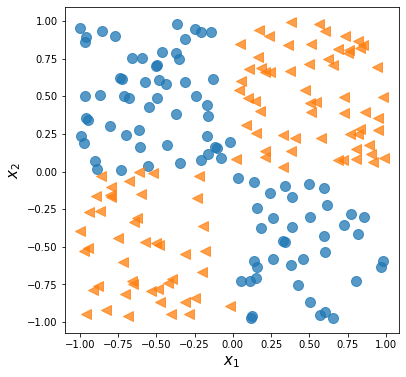

In [48]:
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

$$
    % ローマン体にする
    {y^{(i)}} =
        \begin{cases}
            0 \quad x_1^{(i)} ×　x_2^{(i)} < 0 \\
            1 \quad x_1^{(i)} ×　x_2^{(i)} \geqq 0 \\
        \end{cases}
$$

* 仮説：
    * 出力ラベル$y=1$の確率の推定モデル：$$a^{out}=\sigma(w_0+w_1x_1+\cdots+w_dx_d), \text{ $\sigma(z)$はsigmoid関数とする。}$$
    * 確率の推定値が0.5より大きければ$1$, 小さければ$0$と予測する。

* 損失関数：交差エントロピー損失
\begin{eqnarray*}
L(w)=\begin{cases}
-\log(a^{(i)})\text{ if }y^{(i)} = 1\\
-\log(1-a^{(i)})\text{ if }y^{(i)} =0
\end{cases}
\end{eqnarray*}


学習時には、各データ点に対して交差エントロピー損失を計算し、その平均値が最も小さくなるような1次式を予測器として求める。（正則化項を加えたコスト関数J(W)を最小化）

$$J(w) = -\big\lbrack\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{t}y_j\log(a_j^{(i)})+(1-y_j)\log(1-a_j^{(i)})\big\rbrack+\frac{\lambda}{2}\sum_{l=1}^{L-1}\sum_{i=1}^{u_l}\sum_{j=1}^{u_{l+1}}||w_{j, i}^{(l)}||_2^2$$

#### 1.ロジスティック回帰（単相ニューラルネットワーク）
#### 2.Sequentialクラスを用いる（簡単にモデルの構築ができる）
#### 3.Functional APIを用いる（複雑なモデルを構築できる）
#### 4.サブクラス化を用いる（複雑なモデルを構築できる）
#### 5.NoisyLinear(サブクラス）を用いる

In [87]:
import pandas as pd

xor = pd.DataFrame({'x1':[0, 0, 1, 1], 'x2': [0, 1, 0, 1], 'y':[0, 1, 1, 0]})
xor

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


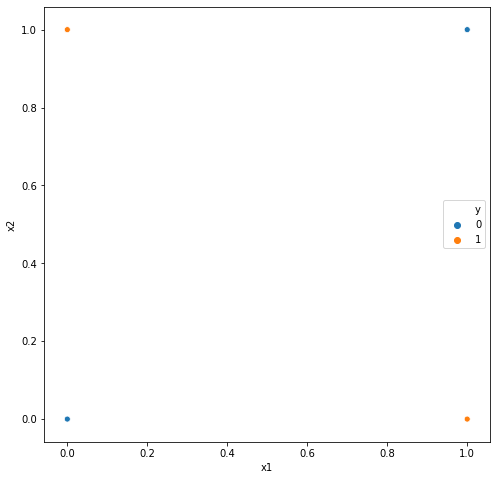

In [88]:
import seaborn as sns

fig = plt.figure(figsize=(8, 8))
sns.scatterplot(data=xor, x='x1', y='x2', hue='y')

In [21]:
# ベースラインとして単純なモデルから始める
# ユニット１， 入力2＋バイアス, 活性化関数シグモイド
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, 
                                input_shape=(2,),
                                activation='sigmoid'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [25]:
import time

In [27]:
t1 = time.time()

hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

t2 = time.time()
print(f'経過時間:{t2-t1:.4f}s')

経過時間:21.1908s


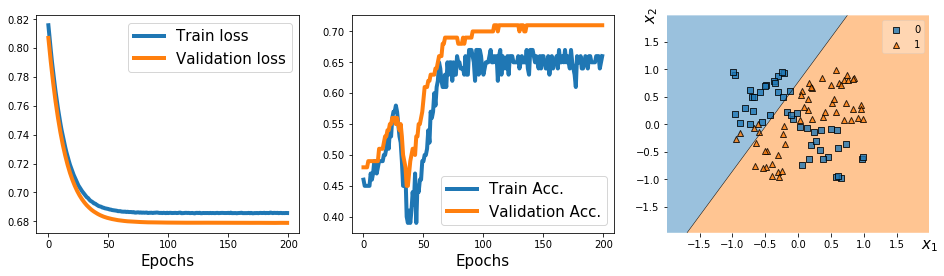

In [24]:
from mlxtend.plotting import plot_decision_regions

history = hist.history


def show_history(history):

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history['loss'], lw=4)
    plt.plot(history['val_loss'], lw=4)
    plt.legend(['Train loss', 'Validation loss'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)

    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history['binary_accuracy'], lw=4)
    plt.plot(history['val_binary_accuracy'], lw=4)
    plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)

    ax = fig.add_subplot(1, 3, 3)
    plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                          clf=model)
    ax.set_xlabel(r'$x_1$', size=15)
    ax.xaxis.set_label_coords(1, -0.025)
    ax.set_ylabel(r'$x_2$', size=15)
    ax.yaxis.set_label_coords(-0.025, 1)
    plt.show()
    
show_history(history)


隠れ層を持たない単純なモデルは線形の決定境界しか抽出できないためXOR問題を解くのは不可能

訓練データと検証データの両方で損失項の値が非常に大きいことと分類正解率が非常に低いこと

検証データセットで満足する結果が観測されるまで隠れユニットの個数を変えながら比較してみる

### Sequentialクラス

In [28]:
# 4つのユニットを持つ３つの隠れ層からなるニューラルネットワーク

tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
t1 = time.time()

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

t2 = time.time()
print(f'経過時間:{t2-t1:.4f}s')

history = hist.history

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
経過時間:25.0581s


In [31]:
# 4つのユニットを持つ３つの隠れ層からなるニューラルネットワーク

tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
t1 = time.time()

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=1, verbose=0)

t2 = time.time()
print(f'経過時間:{t2-t1:.4f}s')

history = hist.history

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
経過時間:46.2643s


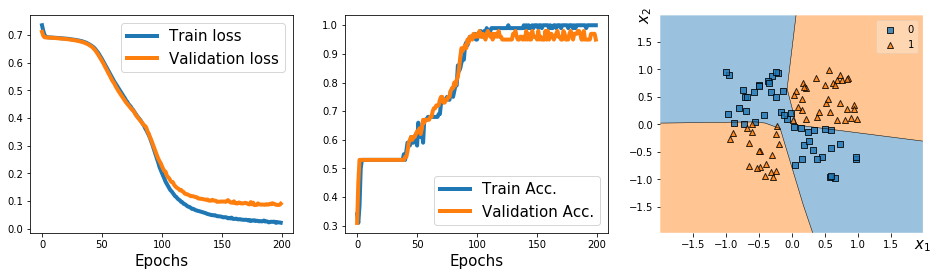

In [29]:
show_history(history)

非線形の決定境界を抽出

訓練データの正解率100%、検証データセット95%　→　過学習

In [122]:
model.predict(x_valid)

array([[0.956876  ],
       [0.98765343],
       [0.06630644],
       [0.5902991 ],
       [0.99774235],
       [0.434168  ],
       [0.9873723 ],
       [0.47118878],
       [0.02597454],
       [0.00407237],
       [0.9571688 ],
       [0.02597454],
       [0.16895908],
       [0.95420325],
       [0.99584293],
       [0.05473787],
       [0.01220518],
       [0.15827405],
       [0.27278608],
       [0.28664792],
       [0.06309414],
       [0.03928414],
       [0.97122777],
       [0.9473719 ],
       [0.9853349 ],
       [0.02597454],
       [0.36199105],
       [0.9546572 ],
       [0.61524457],
       [0.02597454],
       [0.9897412 ],
       [0.98274213],
       [0.01375884],
       [0.17518893],
       [0.3570233 ],
       [0.7140418 ],
       [0.08127666],
       [0.993523  ],
       [0.76632655],
       [0.0475944 ],
       [0.9967358 ],
       [0.02744889],
       [0.02597454],
       [0.7522792 ],
       [0.8073175 ],
       [0.64968413],
       [0.15855435],
       [0.975

### KerasのFunctoionalAPIを使ってより柔軟にモデルを構築

#### 複数の入力、出力、または中間の分岐を持つような複雑なモデルを構築可能

In [37]:
tf.random.set_seed(1)

## input layer:
inputs = tf.keras.Input(shape=(2,))

## hidden layers
h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)  # 各層の出力を次の層の入力として用いる
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)

## output:
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)

## construct a model:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [30]:
## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

t1 = time.time()
## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=1, verbose=0)
t2 = time.time()
print(f'経過時間:{t2-t1:.4f}s')
## Plotting
history = hist.history


経過時間:47.6276s


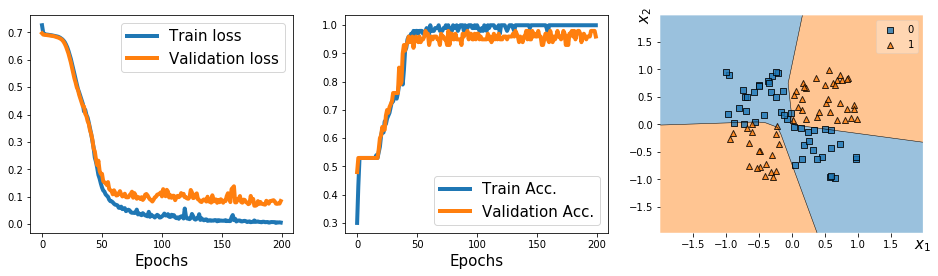

In [39]:
show_history(history)

In [35]:
# サブクラス化

class MyModel(tf.keras.Model):
    
    def __init__(self):  # クラスの属性として層を定義
        super(MyModel, self).__init__()  # tf.keras.Modelのメソッドを継承
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
        
    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)
    
    
tf.random.set_seed(1)

## testing:
model = MyModel()
model.build(input_shape=(None, 2))

model.summary()



Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             multiple                  12        
_________________________________________________________________
dense_18 (Dense)             multiple                  20        
_________________________________________________________________
dense_19 (Dense)             multiple                  20        
_________________________________________________________________
dense_20 (Dense)             multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.get_weights()

[array([[-0.6697383 ,  0.80296254,  0.26194835, -0.13090777],
        [-0.41612196,  0.28500414,  0.951571  , -0.12980103]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[ 0.01750588, -0.09780586, -0.15842533,  0.8530217 ],
        [ 0.3267756 , -0.26699626, -0.11073524,  0.17504281],
        [-0.07512897,  0.43768567, -0.5404047 ,  0.08444953],
        [ 0.08472371,  0.08578336, -0.38123354, -0.67730725]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[ 0.5703252 ,  0.23248965,  0.02550894, -0.18865347],
        [ 0.14012784, -0.7820524 , -0.5583576 ,  0.35455364],
        [-0.01401502, -0.26666218,  0.0137018 , -0.4820744 ],
        [ 0.6037163 ,  0.76918274,  0.04571289, -0.20413756]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[-0.57740456],
        [-0.572319  ],
        [ 0.00795567],
        [ 0.5992962 ]], dtype=float32),
 array([0.], dtype=float32)]

In [36]:
## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
t1 = time.time()
## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=3, verbose=0)
t2 = time.time()
print(f'経過時間:{t2-t1:.4f}s')

## Plotting
history = hist.history


経過時間:18.3546s


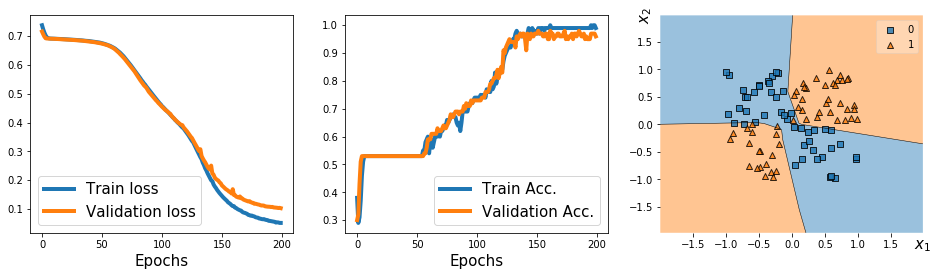

In [34]:
show_history(history)

### サブクラス化の例

####  $$w(x + \epsilon) + b$$

#### データ点にノイズεを加える

In [38]:
# 新しい層を設計したり、既存の層をカスタマイズしたりする場合に便利

class NoisyLinear(tf.keras.layers.Layer):
    
    # 必須
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):  # output_dimを明示的に指定
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev  # データ点のノイズ（正規分布）
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='random_normal',  # 正規分布 N(0, 0.05^2) (Glorotの正規分布ではない)
                                 trainable=True)  # 訓練可能変数
        
        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer='zeros',
                                 trainable=True)
        
    # 必須
    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)  # noise ~ N(0.0, noise_stddev^2)

            noisy_inputs = tf.add(inputs, noise)  # データ点にノイズを加えている
        else:
            noisy_inputs = inputs  #ノイズなし
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)
    
    # Tensorflowモデルの保存と読み込みの機能を使って、このカスタム層を使うモデルを効率よく保存できる
    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev})
        return config



In [39]:
## testing:

tf.random.set_seed(1)

noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(None, 4))

x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))  # activation func: relu

## re-building from config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0 0.00821428 0 0]]
[[0 0.0108502861 0 0]]


In [40]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),  # output_dims = 4
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

model.build(input_shape=(None, 2))
model.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noisy_linear_1 (NoisyLinear) multiple                  12        
_________________________________________________________________
dense_21 (Dense)             multiple                  20        
_________________________________________________________________
dense_22 (Dense)             multiple                  20        
_________________________________________________________________
dense_23 (Dense)             multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [41]:
## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

t1 = time.time()
## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, 
                 verbose=0)
t2 = time.time()
print(f'経過時間:{t2-t1:.4f}s')


経過時間:25.6590s


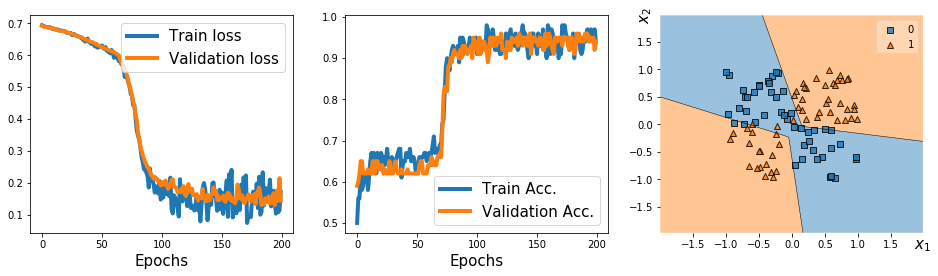

In [36]:
## Plotting
history = hist.history
show_history(history)

tf.keras.layer.Layerのサブクラスとして新しいカスタム層を定義し、Kerasの標準的な層と同じように使う方法を理解することだった。

NoisyLinearは性能の向上に貢献しなかったが、ここでの主な目的はカスタム層を一から記述する方法を理解することにあるので、良しとしよう。

### まとめ

#### GradientTapeによる勾配の計算
#### XOR問題の分類に挑戦
##### &emsp;Sequentialクラスで単層ロジスティック回帰
##### &emsp;Sequentialクラスで4つのユニットと3つの隠れ層
##### &emsp;Fenctional APIで4つのユニットと3つの隠れ層
##### &emsp;カスタム層を追加したサブクラス（データ点にノイズあり）を使ってみた

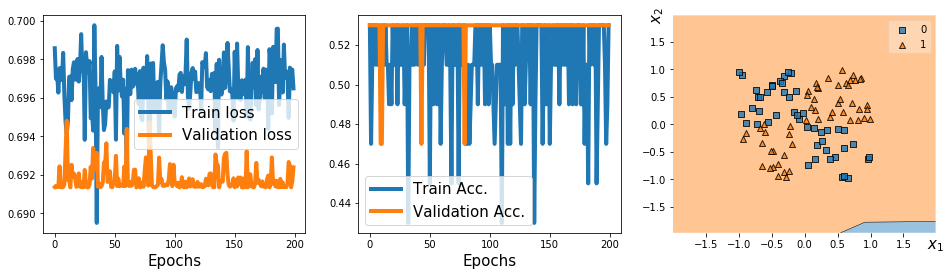

In [134]:
# ハイパーパラメータである学習率を０．１にした結果
history = hist.history
show_history(history)

In [43]:
a = tf.constant([1,2,2,2,5,5], shape=[2,3])
b = tf.constant([1,2,2,2,4,4], shape=[3,2])

c = tf.matmul(a,b)

In [44]:
c

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[13, 14],
       [32, 34]], dtype=int32)>

遅延変数作成・・・インスタンス化のあとにbuildメソッドを呼び出してモデルの層とパラメータを構築すること

XOR分類問題・・・2つのクラス間での非線形の決定境界の補足に関してモデルキャパシティ分析

モデルのキャパシティについて・・・モデルが複雑な関数をどれくらいかんたんに近似できるかの目安

損失関数の選択・・・分類タスクの損失関数は交差エントロピー、回帰問題では平均二乗誤差

最適化アルゴリズムの選択・・・SGDとAdam

KL情報量・・・確率論と情報理論における2つの確率分布の差異を測る尺度。

https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%AB%E3%83%90%E3%83%83%E3%82%AF%E3%83%BB%E3%83%A9%E3%82%A4%E3%83%96%E3%83%A9%E3%83%BC%E6%83%85%E5%A0%B1%E9%87%8F

交差エントロピー誤差関数とロジスティック回帰
https://ja.wikipedia.org/wiki/%E4%BA%A4%E5%B7%AE%E3%82%A8%E3%83%B3%E3%83%88%E3%83%AD%E3%83%94%E3%83%BC

エントロピー・・・確率分布の「複雑さ」を示す値

https://qiita.com/kento1109/items/10026d96f2634ba36362

https://qiita.com/ceptree/items/9a473b5163d5655420e8

http://www.orsj.or.jp/archive2/or60-4/or60_4_191.pdf

In [105]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [1, 0]
y_pred = [0.51, 2.94]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y_true, y_pred).numpy()


8.003291

In [110]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [1]
y_pred = [0.51]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y_true, y_pred).numpy()


0.6733443

In [109]:
np.log(1 / (1 + np.exp(-0.51)))

-0.470313318044875

In [111]:
np.log(0.49)

-0.7133498878774648

In [127]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [0, 1, 0, 0]
y_pred = [-18.6, 0.51, 2.94, -12.8]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred).numpy()


0.865458

In [128]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [0, 1]
y_pred = [-18.6, 0.51]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred).numpy()


0.23515666

In [124]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [1]
y_pred = [0.51]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred).numpy()


0.4703133

In [125]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [0]
y_pred = [2.94]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred).numpy()


2.9915159